In [1]:
version = "REPLACE_PACKAGE_VERSION"

---
# Assignment 2 Part 2: Time Series Similarities (50 pts)

In this assignment, we're going to explore several techniques for measuring similarity between two time series. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Question 1: Load data (5 pts)

We will continue to explore the data we used in Part 1, `assets/time_series_covid19_confirmed_global.csv` from the [Johns Hopkins University CSSE COVID-19 dataset](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series). This time, we are interested in the number of daily new cases **exclusively from the top 5 countries that have the most cumulative cases as of August 21, 2020**. 

Create a function called `load_data` that reads in the csv file and produces a `pd.DataFrame` that looks like: 

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**2020-01-23**|0.0|0.0|0.0|0.0|0.0|
|**2020-01-24**|1.0|0.0|0.0|0.0|0.0|
|**2020-01-25**|0.0|0.0|0.0|0.0|0.0|
|**2020-01-26**|3.0|0.0|0.0|0.0|0.0|
|**2020-01-27**|0.0|0.0|0.0|0.0|0.0|
|**...**|...|...|...|...|...|
|**2020-08-17**|35112.0|19373.0|55018.0|4839.0|2541.0|
|**2020-08-18**|44091.0|47784.0|64572.0|4718.0|2258.0|
|**2020-08-19**|47408.0|49298.0|69672.0|4790.0|3916.0|
|**2020-08-20**|44023.0|45323.0|68900.0|4767.0|3880.0|
|**2020-08-21**|48693.0|30355.0|69876.0|4838.0|3398.0|

where
* the index of the DataFrame is a `pd.DatetimeIndex`; 
* the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from left to right;
* the values of the DataFrame are daily new cases; and
* the DataFrame doesn't contain any `NaN` values. 


**This function should return a `pd.DataFrame` of shape `(212, 5)`, whose index is a `pd.DatetimeIndex` and whose column labels are the top 5 countries.**

In [3]:
def load_data():
    covid_df = pd.read_csv('assets/time_series_covid19_confirmed_global.csv')

    covid_work = covid_df[['Country/Region', '8/21/20']]
    covid_sort = covid_work.sort_values(by=['8/21/20'], ascending = False)
    top_countries = list(covid_sort['Country/Region'].head(5))

    covid_melt = pd.melt(covid_df, id_vars = ['Country/Region', 'Province/State'], value_vars = covid_df.columns[4:],
                         var_name = 'Date', value_name = 'Cumulative_Cases')

    for i in range(len(top_countries)):
        covid_country = covid_melt[covid_melt['Country/Region'] == top_countries[i]]
    
        covid_group = covid_country.groupby('Date').sum().reset_index()
        covid_group['Date_Time'] = pd.to_datetime(covid_group['Date'])
        covid_group.sort_values(by='Date_Time',inplace = True)
        covid_group.drop('Date', axis = 1, inplace = True)
        covid_group.set_index('Date_Time', inplace = True)

        covid_new_cases = covid_group.diff()
        covid_new_cases.rename(columns = {'Cumulative_Cases':top_countries[i]}, inplace=True)
        covid_new_cases.dropna(inplace=True)
    
        if i == 0:
            daily_new_cases = covid_new_cases
        else:
            daily_new_cases[top_countries[i]] = covid_new_cases[top_countries[i]]
    
    return daily_new_cases

In [4]:
# Autograder tests

stu_ans = load_data()

assert isinstance(stu_ans, pd.DataFrame), "Q1: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (212, 5), "Q1: The shape of your pd.DataFrame returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q1: The index of your pd.DataFrame must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q1: The index of your pd.DataFrame contains an incorrect time range. "
assert not stu_ans.isna().any(axis=None), "Q1: Your pd.DataFrame contains NaN values. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q1: All columns of your pd.DataFrame should have a float dtype. "


# Some hidden tests


del stu_ans

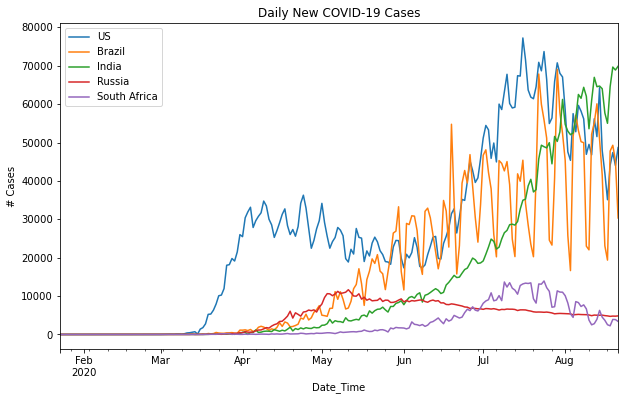

In [5]:
# Let's plot and see the time series
axes = load_data().plot(figsize=(10, 6), title="Daily New COVID-19 Cases", ylabel="# Cases")

del axes

## Question 2: Extract Seasonal Components (5 pts)

Recall from the lectures that an additive Seasonal Decomposition decomposes a time series into the following components:

\begin{equation*}
Y(t) = T(t) + S(t) + R(t)
\end{equation*}

where $T(t)$ represents trends, $S(t)$ represents seasonal patterns and $R(t)$ represents residuals. In the rest of the assignment, we will work with the seasonal component $S(t)$ to understand the similarities among the seasonal patterns of the five time series we have, so let's write a function that extracts this very seasonal component. 

Complete the function below that accepts a `pd.DataFrame` and returns another `pd.DataFrame` of the same shape that looks like:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**2020-01-23**|2431.761670|3380.626554|441.179428|-54.886371|322.986535|
|**2020-01-24**|3446.796153|3457.641332|621.396176|23.689984|362.434811|
|**2020-01-25**|578.564626|586.665963|594.066127|55.034811|391.346141|
|**2020-01-26**|-2728.454422|-6031.950950|46.655454|137.908703|76.880131|
|**2020-01-27**|-3293.854422|-7144.674760|-1234.673118|1.842036|-507.496059|
|**...**|...|...|...|...|...|
|**2020-08-17**|-3293.854422|-7144.674760|-1234.673118|1.842036|-507.496059|
|**2020-08-18**|-719.521088|1549.577621|-544.749308|-28.929392|-662.877011|
|**2020-08-19**|284.707483|4202.114239|76.125240|-134.659770|16.725452|
|**2020-08-20**|2431.761670|3380.626554|441.179428|-54.886371|322.986535|
|**2020-08-21**|3446.796153|3457.641332|621.396176|23.689984|362.434811|

where
* the index of the DataFrame is a `pd.DatetimeIndex`; 
* the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from left to right;
* the values of the DataFrame are the seasonal components $S(t)$ as returned by the `seasonal_decompose` function from `statsmodels`; and
* the DataFrame doesn't contain any `NaN` values. 


**This function should return a `pd.DataFrame` of shape `(len(df), 5)`, whose index is a `pd.DatetimeIndex` and whose column labels are the top 5 countries.**

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

def sea_decomp(df, model="additive"):
    """
    Takes in a DataFrame and extracts the seasonal components
    """
    sea_df = df.apply(lambda x: seasonal_decompose(x, model='additive').seasonal)
    
    return sea_df

In [7]:
# Autograder tests

stu_df = load_data()
stu_ans = sea_decomp(stu_df, "additive")

assert isinstance(stu_ans, pd.DataFrame), "Q2: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (len(stu_df), 5), "Q2: The shape of your pd.DataFrame returned is incorrect. "
assert isinstance(stu_ans.index, pd.DatetimeIndex), "Q2: The index of your pd.DataFrame must be a pd.DatetimeIndex. "
assert (("2020-01-23" <= stu_ans.index) & (stu_ans.index <= "2020-08-21")).all(), "Q2: The index of your pd.DataFrame contains an incorrect time range. "
assert not stu_ans.isna().any(axis=None), "Q2: Your pd.DataFrame contains NaN values. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q2: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

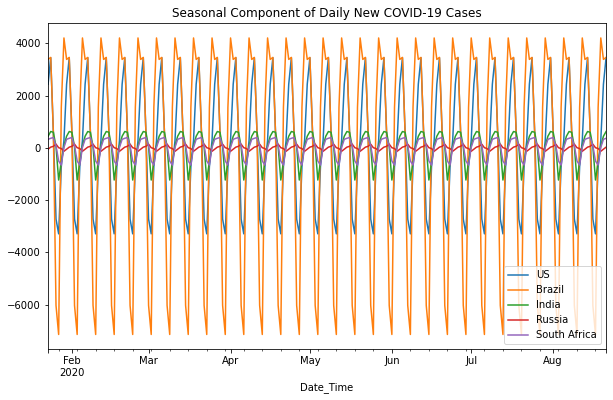

In [8]:
# Let's plot and see the seasonal components

df = load_data()
axes = sea_decomp(df).plot(figsize=(10, 6), title="Seasonal Component of Daily New COVID-19 Cases")

del df, axes

## Question 3: Calculate Euclidean Distance (10 pts)

Now, we may start to ask questions like, "which country in the top 5 countries are the most similar to Country A in terms of seasonal patterns?". In addition to the seasonal components that reflect seasonal patterns, we also need a measure of similarity between two time series in order to answer questions like this. One of such measures is the good old Euclidean Distance. 

Recall that the Euclidean Distance between two vectors $x$ and $y$ is the length of the vector $x - y$:

\begin{equation*}
\mathrm{EucDist}(x, y) = \left\lVert x - y \right\rVert_{2} = \sqrt{\left(x - y\right)^{T}\left(x - y\right)} = \sqrt{\sum_{i = 1}^{n}\left(x_{i} - y_{i}\right)^{2}}
\end{equation*}

Complete the function below that accepts a `pd.DataFrame`, whose columns are time series for each country, and that returns all pairwise Euclidean Distance among these time series, similar to the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**?**|0.000000|233760.757213||||
|**?**|233760.757213|0.000000||||
|**?**|||0.000000|||
|**?**||||0.000000||
|**?**|||||0.000000|

where
* the index and the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from top to bottom and from left to right; and
* the values of the DataFrame are pairwise Euclidean Distance, for example, `233760.757213` is the Euclidean Distance between the time series of the Rank 1 country and the Rank 2 country

**This function should return a `pd.DataFrame` of shape `(5, 5)`, whose index and column labels are the top 5 countries.**

In [9]:
def calc_euclidean_dist(df):
    """
    Takes in a DataFrame and computes all pairwise Euclidean Distance
    """
    num_countries = df.shape[1]
    temp_array = np.zeros((num_countries, num_countries))

    for i in range(num_countries):
        for j in range(num_countries):
            temp_array[i,j] = np.sqrt(np.sum((df.iloc[:,i] - df.iloc[:,j])**2))
        
    euclidean_dist_df = pd.DataFrame(temp_array, columns = list(df.columns))
    euclidean_dist_df.index = list(df.columns)
    
    return euclidean_dist_df

In [10]:
# Autograder tests

stu_df = load_data()
stu_ans = calc_euclidean_dist(stu_df)

assert isinstance(stu_ans, pd.DataFrame), "Q3: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (5, 5), "Q3: The shape of your pd.DataFrame is not correct. "
assert (stu_ans.index == stu_ans.columns).all(), "Q3: Your pd.DataFrame should have the same index and column labels. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q3: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

Now let's calculate the pairwise Euclidean Distance between seasonal patterns. What can you say about the similarities among these seasonal patterns? 

In [11]:
# Let's show the pairwise Euclidean Distance matrix

df = load_data()
calc_euclidean_dist(sea_decomp(df))

,US,Brazil,India,Russia,South Africa
US,0.000000,37616.752035,27032.887714,33986.305519,30084.544171
Brazil,37616.752035,0.000000,57583.437987,63663.896821,60839.376478
India,27032.887714,57583.437987,0.000000,9102.412727,4490.020448
Russia,33986.305519,63663.896821,9102.412727,0.000000,5658.222387
South Africa,30084.544171,60839.376478,4490.020448,5658.222387,0.000000


## Question 4: Calculate Cosine Similarity (10 pts)

Another commonly used similarity measure is the Cosine Similarity. Recall that the Cosine Similarity between two vectors $x$ and $y$ is the cosine of the angle between $x$ and $y$:

\begin{equation*}
\mathrm{CosSim}(x, y) = \frac{x^{T}y}{\left\lVert x \right\rVert_{2} \left\lVert y \right\rVert_{2}} = \left(\frac{x}{\left\lVert x \right\rVert_{2}}\right)^{T}\left(\frac{y}{\left\lVert y \right\rVert_{2}}\right)
\end{equation*}

Complete the function below that accepts a `pd.DataFrame`, whose columns are the time series for each country, and that returns all pairwise Cosine Similarity among these time series, similar to the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**?**|1.000000	|0.898664||||
|**?**|0.898664|1.000000||||
|**?**|||1.000000|||
|**?**||||1.000000||
|**?**|||||1.000000|

where
* the index and the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from top to bottom and from left to right; and
* the values of the DataFrame are pairwise Cosine Similarity, for example, `0.898664` is the Cosine Similarity between the time series of the Rank 1 country and the Rank 2 country

**This function should return a `pd.DataFrame` of shape `(5, 5)`, whose index and column labels are the top 5 countries.**

In [12]:
from numpy.linalg import norm

def calc_cos_sim(df):
    """
    Takes in a DataFrame and computes all pairwise Cosine Similarity
    """
    num_countries = df.shape[1]
    temp_array = np.zeros((num_countries, num_countries))

    for i in range(num_countries):
        for j in range(num_countries):
            temp_array[i,j] = np.dot(df.iloc[:,i], df.iloc[:,j])/(norm(df.iloc[:,i])*norm(df.iloc[:,j]))
        
    cos_sim_df = pd.DataFrame(temp_array, columns = list(df.columns))
    cos_sim_df.index = list(df.columns)
    
    return cos_sim_df

In [13]:
# Autograder tests

stu_df = load_data()
stu_ans = calc_cos_sim(stu_df)

assert isinstance(stu_ans, pd.DataFrame), "Q4: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (5, 5), "Q4: The shape of your pd.DataFrame is not correct. "
assert (stu_ans.index == stu_ans.columns).all(), "Q4: Your pd.DataFrame should have the same index and column labels. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q4: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

Now let's calculate the pairwise Cosine Similarity between seasonal patterns. What can you say about the similarities among these seasonal patterns? 

In [14]:
# Let's show the pairwise Cosine Similarity matrix

df = load_data()
calc_cos_sim(sea_decomp(df))

,US,Brazil,India,Russia,South Africa
US,1.000000,0.868859,0.783851,-0.325065,0.664261
Brazil,0.868859,1.000000,0.632741,-0.629987,0.403198
India,0.783851,0.632741,1.000000,0.092292,0.917529
Russia,-0.325065,-0.629987,0.092292,1.000000,0.174437
South Africa,0.664261,0.403198,0.917529,0.174437,1.000000


## Question 5: Calculate Dynamic Time Warping (DTW) Cost (20 pts)

Last but not least, the cost of aligning two time series can also be used as a similarity measure. Two time series are more similar if it incurs less cost to align them. One of the commonly used alignment costs is the Dynamic Time Warping (DTW) cost, which we will explore in this problem. 

### Question 5a (10 pts)

Recall from the lectures that the DTW cost is defined by the following recursive relations:

\begin{align}
&\mathrm{DTW}(1, 1)  = d(x_{1}, y_{1}) \\
&\mathrm{DTW}(i, j)  = d(x_{i}, y_{j}) + \min \begin{cases}
\mathrm{DTW}(i, j - 1) & \text{Repeat } x_{i} \\
\mathrm{DTW}(i - 1, j) & \text{Repeat } y_{j} \\
\mathrm{DTW}(i - 1, j - 1) & \text{Both proceed}
\end{cases}
\end{align}

where we define $d(x_{i}, y_{j}) = (x_{i} - y_{j})^{2}$ as in the lectures. With reference to the demo of the DTW algorithm in the lecture slides, implement the function below that computes the DTW cost for two time series. **We don't take the square root of the results just yet, until later when we compare the DTW costs with the Euclidean Distance.**

**This function should EITHER return a `np.ndarray` of shape `(len(y), len(x))` which represents the DTW cost matrix, OR a single `float` that represents the overall DTW cost, depending whether the parameter `ret_matrix=True`.**

In [15]:
import math

def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """
    Takes in two series. If ret_matrix=True, returns the full DTW cost matrix; 
    otherwise, returns only the overall DTW cost
    """
    
    cost_matrix = np.zeros((len(y), len(x)))
    
    dist_fn = lambda a, b: (a - b) ** 2  # Optional helper function
    
    #handle first value
    cost_matrix[0,0] = dist_fn(x[0], y[0])

    #handle first (y) column
    for j in range(1, len(y)):
        cost_matrix[j, 0] = dist_fn(y[j], x[0]) + cost_matrix[j-1, 0] 

    #handle first (x) row
    for i in range(1, len(x)):
        cost_matrix[0, i] = dist_fn(y[0], x[i]) + cost_matrix[0, i-1] 

    #handle everything else
    for i in range(1, len(x)):
        for j in range(1, len(y)): #min of left, up, or up-left
            cost_matrix[j, i] = min(cost_matrix[j-1, i], cost_matrix[j, i-1], cost_matrix[j-1, i-1]) + dist_fn(y[j], x[i])
        
    dtw_cost = cost_matrix[len(y) - 1, len(x) - 1]
    
    return cost_matrix if ret_matrix else dtw_cost

In [16]:
# Autograder tests

stu_df = load_data()

# First test with ret_matrix=False
stu_ans = calc_pairwise_dtw_cost(stu_df.iloc[:, 0], stu_df.iloc[:, 1], ret_matrix=False)
assert isinstance(stu_ans, float), "Q5a: Your function should return a float with ret_matrix=False. "
assert np.isclose(stu_ans, 9575974038.0), "Q5a: The DTW cost between Rank 1 and Rank 2 countries is not correct. "

# Then test with ret_matrix=True
stu_ans = calc_pairwise_dtw_cost(stu_df.iloc[:, 0], stu_df.iloc[:, 1], ret_matrix=True)
assert isinstance(stu_ans, np.ndarray), "Q5a: Your function should return a np.ndarray with ret_matrix=True. "
assert stu_ans.shape == (len(stu_df), len(stu_df)), "Q5a: The shape of your np.ndarray is not correct. "
assert np.issubdtype(stu_ans.dtype, np.floating), "Q5a: Your np.ndarray should have a float dtype. "

# Also test with reversing the order of the inputs
stu_ans_T = calc_pairwise_dtw_cost(stu_df.iloc[:, 1], stu_df.iloc[:, 0], ret_matrix=True)
assert np.isclose(stu_ans.T, stu_ans_T).all(), "Q5a: When the order of the inputs is reversed, your new cost matrix should be the old one's transpose. "

# Some hidden tests - for Rank 1 and Rank 2 countries


del stu_df, stu_ans

### Question 5b (10 pts)

Now let's compute all pairwise DTW costs for our five time series. Complete the function below that accepts a `pd.DataFrame`, whose columns are the time series for each country, and that returns all pairwise DTW costs among these time series, similar to the following:

| | ? | ? | ? | ? | ? |
|-: | -: | -: | -: | -: | -: |
|**?**|0.000000e+00		|9.575974e+09||||
|**?**|9.575974e+09|0.000000e+00	||||
|**?**|||0.000000e+00	|||
|**?**||||0.000000e+00	||
|**?**|||||0.000000e+00	|

where
* the index and the column names "?" are the top 5 countries with the most cumulative cases as of August 21, 2020, sorted in descending order from top to bottom and from left to right; and
* the values of the DataFrame are pairwise DTW costs, for example, `9.575974e+09` is the DTW cost between the time series of the Rank 1 country and the Rank 2 country

**This function should return a `pd.DataFrame` of shape `(5, 5)`, whose index and column labels are the top 5 countries.**

In [17]:
def calc_dtw_cost(df):
    """
    Takes in a DataFrame and computes all pairwise DTW costs
    """
    
    num_countries = df.shape[1]
    temp_array = np.zeros((num_countries, num_countries))

    for i in range(num_countries):
        for j in range(num_countries):
            temp_array[i,j] = calc_pairwise_dtw_cost(df.iloc[:, i], df.iloc[:, j], ret_matrix=False)
        
    dtw_cost_df = pd.DataFrame(temp_array, columns = list(df.columns))
    dtw_cost_df.index = list(df.columns)
    
    return dtw_cost_df

In [18]:
# Autograder tests - takes some time

stu_df = load_data()
stu_ans = calc_dtw_cost(stu_df)

assert isinstance(stu_ans, pd.DataFrame), "Q5b: Your function should return a pd.DataFrame. "
assert stu_ans.shape == (5, 5), "Q5b: The shape of your pd.DataFrame is not correct. "
assert (stu_ans.index == stu_ans.columns).all(), "Q5b: Your pd.DataFrame should have the same index and column labels. "
assert stu_ans.dtypes.apply(lambda x: np.issubdtype(x, np.floating)).all(), "Q5b: All columns of your pd.DataFrame should have a float dtype. "

# Some hidden tests


del stu_df, stu_ans

Now let's calculate the pairwise DTW costs between seasonal patterns. **Take the sqaure root so that we can compare it with the Euclidean Distance**. What can you say about the similarities among these seasonal patterns? 

In [19]:
# Let's show the pairwise DTW costs matrix

df = load_data()
np.sqrt(calc_dtw_cost(sea_decomp(df)))

,US,Brazil,India,Russia,South Africa
US,0.000000,31878.178988,23565.948799,32327.414867,28016.515162
Brazil,31878.178988,0.000000,53400.789074,61868.013722,57143.198022
India,23565.948799,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.414867,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.515162,57143.198022,4463.425362,4259.096369,0.000000
